In [3]:
# -*- coding: utf-8 -*-
"""
Created in June 2023

Content: 3 years data (2022-2024) (Random sampling 30%error)
Prediction on hourly data using single LSTM layer and Multiple LSTM layer, 512 neuron, learningrate =0.001
@author: Thai Thai Son
"""

'\nCreated in June 2023\n\nContent: 3 years data (2022-2024) (Random sampling 30%error)\nPrediction on hourly data using single LSTM layer and Multiple LSTM layer, 512 neuron, learningrate =0.001\n@author: Thai Thai Son\n'

In [4]:
# import libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras import metrics
from keras.models import load_model
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.layers import InputLayer

In [5]:
#Import dataset
df = pd.read_csv("DomesticHotWaterProfile.csv")
print("="*50)
print("First Five Rows ","\n")
print(df.head(5),"\n")

#Use time column as index
df = df.set_index('Time')
df.index=pd.to_datetime(df.index)

#resamplingdata to hourly interval
df = df.iloc[:,0:1]
df = df.resample('3600s').sum()
Flow = df['Flowrate (l/min)']

#adding column to indicate weekend-1, weekday-0, hour of day
df["Hour_of_day"] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_week'] = df['day_of_week'].replace([0,1,2,3,4,5,6],[0,0,0,0,0,1,1])

#training set, testing set split 
df_for_training=df[:23000]
df_for_test=df[23000:]

#assign value for X_train, y_train, X_test, y_test
def df_to_X_y2(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)
X_train,y_train=df_to_X_y2(df_for_training)
X_test, y_test=df_to_X_y2(df_for_test)


#learningrate
lr1=0.001


First Five Rows  

              Time  Flowrate (l/min)
0  2022-01-01 0:00               0.0
1  2022-01-01 0:15               0.0
2  2022-01-01 0:30               0.0
3  2022-01-01 0:45               0.0
4  2022-01-01 1:00               0.0 



In [6]:
#model1: single LSTM layer model
#model1: 512 neurons, 1LSTM layer
model1 = Sequential()
model1.add(LSTM(units=512, input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Dense(32, 'relu'))
model1.add(Dense(1, 'linear')) 
model1.compile(optimizer=Adam(learning_rate=lr1), loss = MeanSquaredError(),metrics=[RootMeanSquaredError()])
model1.summary()
model1.fit(X_train,y_train,epochs=100,batch_size=16,validation_split=0.1)
model1.save('model1.h5') 
#model1=load_model('model1.h5')

In [7]:
#model2: Two LSTM layer models
#model2: 2LSTM layers (512-512 neurons)
model2 = Sequential()
model2.add(LSTM(units=512, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model2.add(LSTM(512))
model2.add(Dense(32, 'relu'))
model2.add(Dense(1, 'linear')) 
model2.compile(optimizer=Adam(learning_rate=lr1), loss = MeanSquaredError(),metrics=[RootMeanSquaredError()])
model2.summary()
model2.fit(X_train,y_train,epochs=100,batch_size=16,validation_split=0.1)
model2.save('model2.h5') 
#model2=load_model('model2.h5')

In [8]:
#Define function for figures
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=500):
  predictions = model.predict(X).flatten()
  df1 = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  fig, ax=plt.subplots(figsize=(10,6)) 
  plt.plot(df1['Predictions'][start:end],'b',alpha=0.8)
  plt.plot(df1['Actuals'][start:end],'red',alpha=0.6, linewidth=0.8)
  plt.gca().legend(('Prediction','Actuals'))
  ax.grid(axis='y', linestyle=':', alpha=0.5)
  ax.grid(axis='x', linestyle=':', alpha=0.5)
  ax.tick_params(axis='both', which='major', labelsize=12)
  plt.ylabel('Hot water demand [l/min]', fontsize=14, labelpad=10)
  plt.xlabel('Time [hour]', fontsize=14, labelpad=10)
  ax.set_ylim(0)
  ax.set_xlim(start)
  #plt.show()
  print(df1)
  return df1, mse(y, predictions),predictions

#Predictions made by single layers model
predictions1 = model1.predict(X_test).flatten()
test_rmse_model1 = np.sqrt(mse(y_test, predictions1))
print('Test RMSE model1:', test_rmse_model1)


103/103 [==============================] - 2s 13ms/step
Test RMSE model1: 4.520982336269552


In [9]:
#Predictions made by multiple layers model
predictions2 = model2.predict(X_test).flatten()
test_rmse_model2 = np.sqrt(mse(y_test, predictions2))
print('Test RMSE best model2:', test_rmse_model2)

103/103 [==============================] - 4s 32ms/step
Test RMSE best model2: 3.245455359545684


719/719 [==============================] - 11s 15ms/step
       Predictions  Actuals
0        13.140566     11.8
1        14.965817     17.2
2        10.573599     10.8
3        10.191837     11.2
4         2.276875      2.6
...            ...      ...
22985     0.247141      0.0
22986    -0.488893      0.4
22987    -0.650170      0.0
22988    10.058311      8.8
22989     7.130290      8.6

[22990 rows x 2 columns]


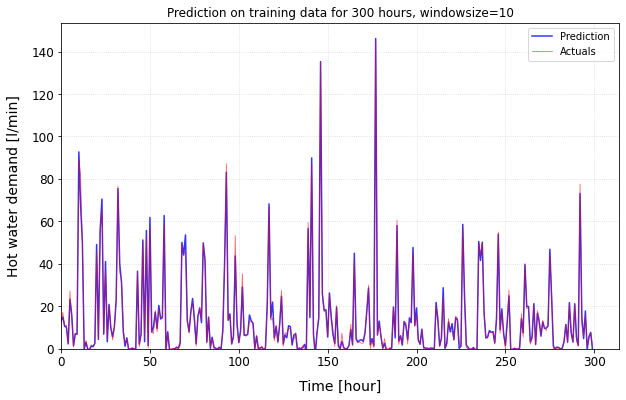

103/103 [==============================] - 2s 15ms/step
      Predictions  Actuals
0       -0.031078      0.8
1        2.049543      3.6
2        0.504632      0.0
3        2.731396      0.0
4        0.995116      0.0
...           ...      ...
3289    20.552290     27.5
3290    59.929470     69.6
3291    29.300362     29.0
3292     9.245385      4.1
3293     4.880578      0.0

[3294 rows x 2 columns]


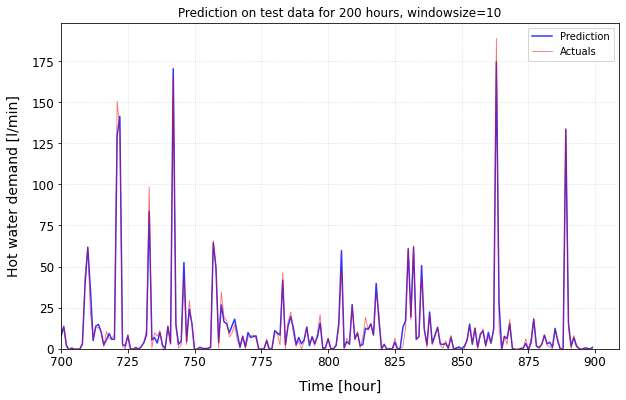

103/103 [==============================] - 2s 14ms/step
      Predictions  Actuals
0       -0.031078      0.8
1        2.049543      3.6
2        0.504632      0.0
3        2.731396      0.0
4        0.995116      0.0
...           ...      ...
3289    20.552290     27.5
3290    59.929470     69.6
3291    29.300362     29.0
3292     9.245385      4.1
3293     4.880578      0.0

[3294 rows x 2 columns]


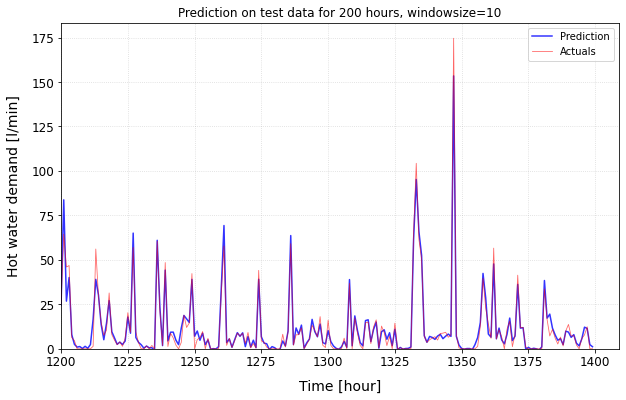

In [10]:
#Plot prediction on testing data and training data for single-layer model
plot_predictions1(model1, X_train, y_train,0,300)
plt.title('Prediction on training data for 300 hours, windowsize=10')
plt.show()


plot_predictions1(model1, X_test, y_test,700,900)
plt.title('Prediction on test data for 200 hours, windowsize=10')
plt.show()


plot_predictions1(model1, X_test, y_test,1200,1400)
plt.title('Prediction on test data for 200 hours, windowsize=10')
plt.show()

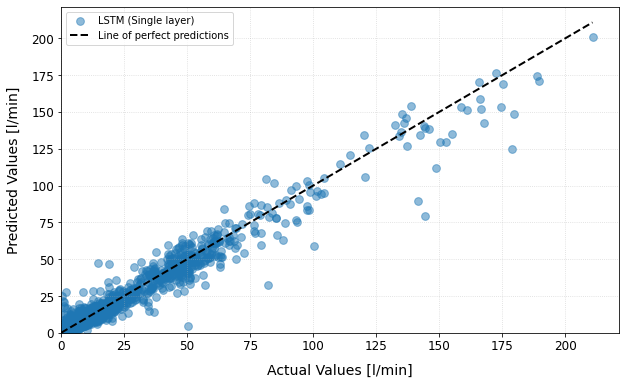

In [11]:
#Plot performance curve for single layer model
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, predictions1, alpha=0.5, s=60)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual Values [l/min]', fontsize=14, labelpad=10)
ax.set_ylabel('Predicted Values [l/min]', fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.grid(axis='x', linestyle=':', alpha=0.5)
plt.gca().legend(('LSTM (Single layer)','Line of perfect predictions'))
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()

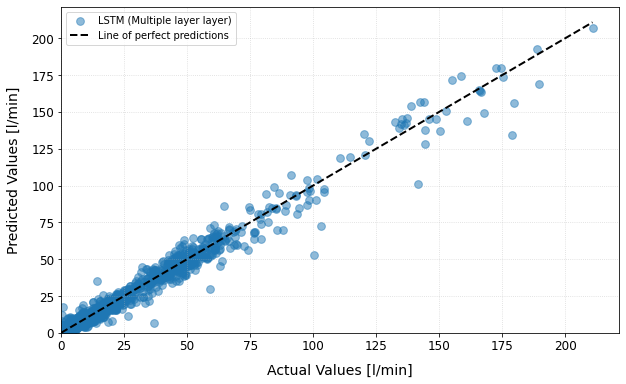

In [16]:
#Plot performance curve for multipl - layer model
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, predictions2, alpha=0.5, s=60)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual Values [l/min]', fontsize=14, labelpad=10)
ax.set_ylabel('Predicted Values [l/min]', fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.grid(axis='x', linestyle=':', alpha=0.5)
plt.gca().legend(('LSTM (Multiple layer layer)','Line of perfect predictions'))
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()

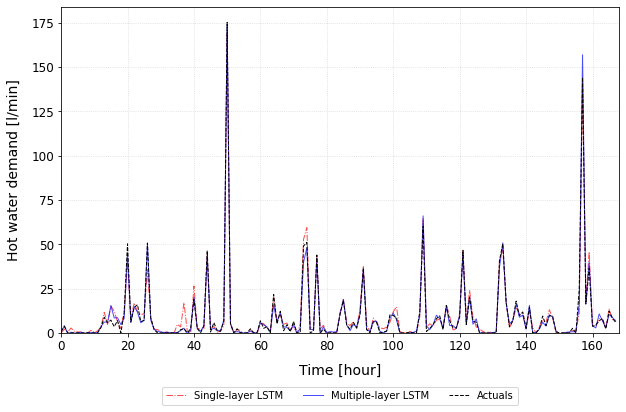

In [13]:
#Comparison between predictions made by 2 models and actual value
df1 = pd.DataFrame(data={'Predictions':predictions1,'Predictions2':predictions2, 'Actuals':y_test})
fig, ax=plt.subplots(figsize=(10,6)) 
ax.plot(df1['Predictions'][0:168],'r-.',alpha=0.7,linewidth=1,label='Single-layer LSTM')
ax.plot(df1['Predictions2'][0:168],'blue',alpha=0.7,linewidth=1,label='Multiple-layer LSTM')
ax.plot(df1['Actuals'][0:168],'k--',alpha=1, linewidth=1,label='Actuals')
ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.grid(axis='x', linestyle=':', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Hot water demand [l/min]', fontsize=14, labelpad=10)
plt.xlabel('Time [hour]', fontsize=14, labelpad=10)
ax.set_ylim(0)
ax.set_xlim(0,168)
ax.legend()
# place legend outside of the box and in horizontal order
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.savefig('ModelComparison1week.png',dpi=600,facecolor='white', bbox_inches='tight')
plt.show()

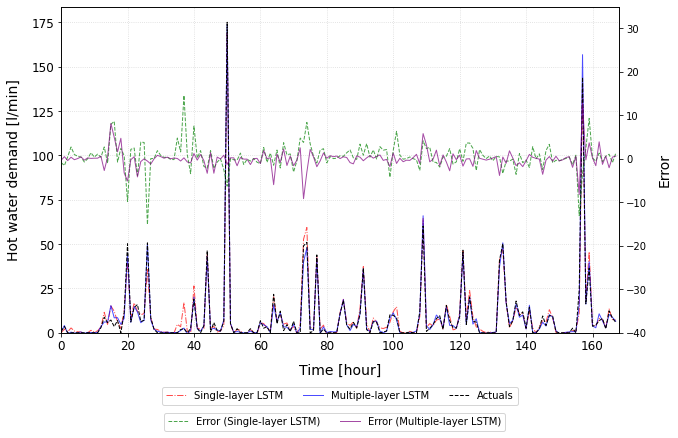

In [14]:
#Comparison between predictions made by 2 models and actual value with error
df1 = pd.DataFrame(data={'Predictions':predictions1,'Predictions2':predictions2, 'Actuals':y_test})
fig, ax=plt.subplots(figsize=(10,6)) 

# Calculate the errors
error1 = df1['Predictions'] - df1['Actuals']
error2 = df1['Predictions2'] - df1['Actuals']

ax.plot(df1['Predictions'][0:168],'r-.',alpha=0.7,linewidth=1,label='Single-layer LSTM')
ax.plot(df1['Predictions2'][0:168],'blue',alpha=0.7,linewidth=1,label='Multiple-layer LSTM')
ax.plot(df1['Actuals'][0:168],'k--',alpha=1, linewidth=1,label='Actuals')

# Create a secondary y-axis for the errors
ax2 = ax.twinx()
ax2.plot(error1[0:168], 'g--', alpha=0.7, linewidth=1, label='Error (Single-layer LSTM)')
ax2.plot(error2[0:168], 'purple', alpha=0.7, linewidth=1, label='Error (Multiple-layer LSTM)')

ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.grid(axis='x', linestyle=':', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Time [hour]', fontsize=14, labelpad=10)
ax.set_ylabel('Hot water demand [l/min]', fontsize=14, labelpad=10)
ax2.set_ylabel('Error', fontsize=14, labelpad=10)
ax2.set_ylim(-40,35)
ax.set_ylim(0)
ax.set_xlim(0,168)
ax.legend()
ax2.legend()
# place legend outside of the box and in horizontal order
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax2.legend(loc='upper center', bbox_to_anchor=(0.49, -0.23),ncol=2)
plt.savefig('ModelComparison1week_v2.png',dpi=600,facecolor='white', bbox_inches='tight')
plt.show()

In [15]:
#Calculation of Mean Absolute Scaled Error (MASE)
def mase(y_true, y_pred, seasonality):
    """
    Calculate the Mean Absolute Scaled Error (MASE).
    
    Parameters:
        y_true (array-like): The true values of the time series.
        y_pred (array-like): The predicted values of the time series.
        seasonality (int): The seasonal period of the time series.
        
    Returns:
        The MASE value.
    """
    n = len(y_true)
    naive = np.roll(y_true, seasonality)
    errors = np.abs(y_true - y_pred)
    scaled_errors = errors / (np.sum(np.abs(y_true - naive)) / (n - seasonality))
    return np.mean(scaled_errors)
mase_value2 = mase(y_test, predictions2, 24)
print("MASE value:", mase_value2)

MASE value: 0.11101848477170076
